# Demonstration of Fly-Scanning

This notebook covers how to perform a fly-scan, where one motor moves continuously while one or more detectors acquire multiple data points.

This includes the following tasks:
- preparing an axis on the Aerotech XY stage as a flyer
- executing a 1D fly-scan over an Aerotech axis
- loading 1D fly-scan data from the database
- executing a 2D scan where one axis is flown
- loading 2D fly-scan data from the database

First we have to import haven, the beamline control library. Haven contains most of the tools we will use. Importing it allows us to get to the functions and classes that are defined inside.

Next, the ``haven.load_instrument()`` function will read the configuration files and scan the hardware for its configuration. It will then **build the devices** that will be used for scans. This function prints out a list of motors that it has discovered.

Then, we create the run engine. The run engine is responsible for executing our scans and will be described in more detail when it is used below.

Lastly we set metadata about who is running the beamline. This value will be saved in every plan executing on this run engine. This step is optional, but will allow database queries for scans taken by a specific person.

In [21]:
# Import support packages
import matplotlib.pyplot as plt
import numpy as np
# Import haven
import haven
# Load the motors and detectors
haven.load_instrument()
# The RunEngine will be responsible for executing the plans
RE = haven.run_engine()
# (Optional) Save the initials of the current beamline operator as metadata
RE.md["operator"] = "MFW"  # <- Put your initials in here

Could not connect to AravisDetector in 2.27 sec: Hutch A BPM.
Could not connect to AravisDetector in 2.27 sec: s25id-gige-A.
Could not connect to AravisDetector in 2.27 sec: s25id-gige-C.
Could not connect to AravisDetector in 2.27 sec: s25id-gige-D.
Could not connect to AravisDetector in 2.27 sec: s25id-gige-E.
Could not connect to ApsPssShutterWithStatus in 2.27 sec: front_end_shutter.
Could not connect to ApsPssShutterWithStatus in 2.27 sec: hutch_shutter.
Could not connect to ApsMachine in 2.27 sec: APS.
Could not connect to Monochromator in 2.21 sec: monochromator.
Could not connect to ApsUndulator in 2.21 sec: undulator.
Could not connect to energy positioner: energy
Could not connect to fluorescence detector: canberra_Ge7 (20xmap8:)
Could not connect to motor: 25ida:ORM1:m1
Could not connect to motor: 25ida:ORM1:m2
Could not connect to motor: 25ida:ORM1:m3
Could not connect to motor: 25ida:ORM1:m4
Could not connect to motor: 25ida:ORM2:m1
Could not connect to motor: 25ida:ORM2:m

## Preparing the Aerotech Flyer

We need to get the horizontal axis of the aerotech XY stage as an Ophyd device, and the ion chambers to use as detectors.

This can be done easily with the Haven registry.

We will also use a **0.2 sec dwell time** for the rest of this tutorial, which we set on the device now.

In [2]:
aerotech = haven.registry.find("aerotech")
# Set dwell time here
dwell_time = 0.2  # seconds
aerotech.horiz.dwell_time.set(dwell_time).wait()
# Get ion chamber devices
ion_chambers = haven.registry.findall("ion_chambers")

## 1D Fly-Scan

Now we will **create the plan** to run the fly scan.

We need to provide the *start* and *end* positions for the scan. For easy comparison to regular step scans, the *start* and *stop* positions are the motor position at the center of the first and last bins of the scan.

We also need to inform the plan how often to make a new data bin. *num* tells the plan how many bins to create. The example code will produce 41 bins between −1000µm and 1000µm, which means each bin will cover 50µm.

In [3]:
start, stop, num = (-1000, 1000, 41)
plan = haven.fly_scan(ion_chambers, aerotech.horiz, start, stop, num)
uid, = RE(plan, purpose="fly scanning tutorial", sample="")
print(f"Scan complete. UID: {uid}")

/home/beams0/S25IDCUSER/micromamba/envs/haven-dev/lib/python3.9/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


Scan complete. UID: 0ebb79bd-eea1-4ff2-8a2e-5c4915cd13fc


### Viewing 1D Fly-Scan Results

Text(0, 0.5, 'It net counts')

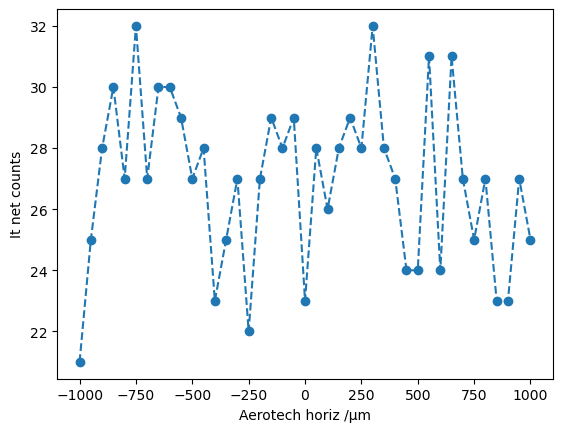

In [41]:
# Load the data from the mongodb database
client = haven.tiled_client()
uid = "0ebb79bd-eea1-4ff2-8a2e-5c4915cd13fc"
data = client[uid]['primary']['data'].read()

# Create a new set of axes for plotting
plt.figure()
ax = plt.gca()
# Plot It versus motor position (w/o offset for now)
ax.plot(data.aerotech_horiz, data.Ipre_KB_net_counts, marker='o', linestyle="--")
ax.set_xlabel("Aerotech horiz /µm")
ax.set_ylabel("It net counts")

## 2D Map Fly-Scanning

In this section we will fly the horizontal axis and step the vertical axis.

Instead of ``fly_scan()`` we will use ``grid_fly_scan()``. 

In [7]:
# Set parameters for fly scan here
step_params = (-1500, 500, 21)  # (start, stop, num)
fly_params = (-1000, 1000, 41)  # (start, stop, num)
# Create the plan, slow axis listed first
plan = haven.grid_fly_scan(ion_chambers, aerotech.vert, *step_params, aerotech.horiz, *fly_params, snake_axes=True)
# Execute the plan
uid, = RE(plan, purpose="fly scanning tutorial", sample="")
print(f"Scan complete. UID: {uid}")

/home/beams0/S25IDCUSER/micromamba/envs/haven-dev/lib/python3.9/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


Scan complete. UID: 5e00f671-7b4b-4215-8ed9-224566a6fa35


### Viewing 2D Fly-Scan Results

In [39]:
# Load the data from the mongodb database
client = haven.tiled_client()
uid = "5e00f671-7b4b-4215-8ed9-224566a6fa35"
# Get the shape of the map from the metadata
metadata = client[uid].metadata
extent = (*metadata['start']['extents'][1], *metadata['start']['extents'][0])
shape = metadata['start']['shape']
# Read and re-shape the data
data = client[uid]['primary']['data'].read()

Text(0, 0.5, 'Aerotech vert /µm')

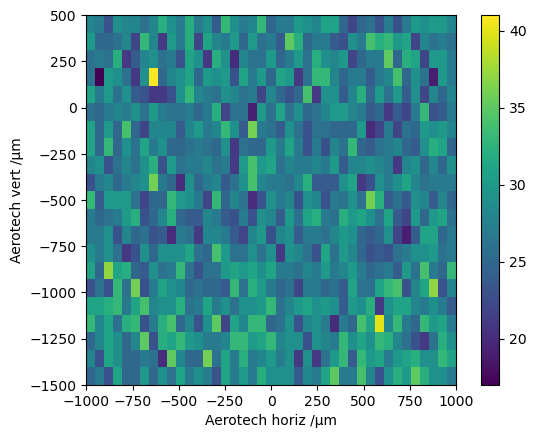

In [40]:
# Create a new set of axes for plotting
plt.figure()
ax = plt.gca()
# Plot a map of It measurements (w/o offset for now)
I0 = np.reshape(np.asarray(data.Ipre_KB_net_counts), shape)
im = ax.imshow(I0, extent=extent, origin="lower")
plt.colorbar(im, ax=ax)
ax.set_xlabel("Aerotech horiz /µm")
ax.set_ylabel("Aerotech vert /µm")